In [31]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [32]:
import torch
from torch_geometric.datasets import Planetoid

# download dataset using ogb pytorch geometric loader.
dataset = Planetoid("dataset", "Cora")

data = dataset[0] # pyg graph object

print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [15, 12]
font = {'size': 32}
matplotlib.rc('font', **font)
alpha = 1

y = data.y.reshape(-1).detach().numpy()
classes = np.unique(y)
bins = np.append(classes, np.max(y)+1)

hist = plt.hist(y, bins=bins, rwidth=0.8, color="#4363d8")
print(hist)

plt.xticks(classes+0.5, classes)
#plt.ylim(ymin=ymin, ymax=ymax)
#plt.legend(ncol=3)
plt.title("Class distribution - Cora")
plt.xlabel("Class")
plt.ylabel("Number of node")
plt.grid(True)

plt.tight_layout()
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)
#plt.savefig(f"{output_dir}/cora-class-dist.png")
plt.close()
# plt.show()

(array([351., 217., 418., 818., 426., 298., 180.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>)


graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 78
graph has # isolated nodes: 0


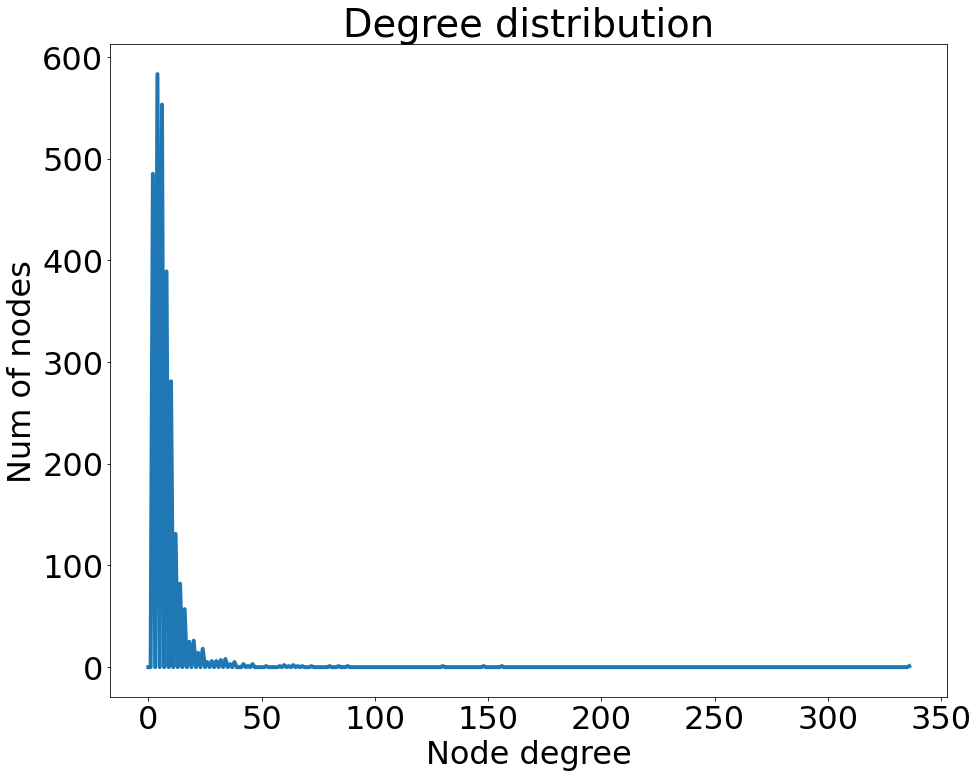

In [34]:
from lib import util

util.describe_graph(data, save_fig=True)

## Split data set

In [35]:
from lib.data import split_dataset

train_data, calibration_indices, test_indices = split_dataset(data, test_frac=0.2, calibration_frac=0.2)

print("Train set: {}".format(train_data))
print("Calibration set size: {}".format(len(calibration_indices)))
print("Test set size: {}".format(len(test_indices)))

Train set: Data(x=[1625, 1433], edge_index=[2, 3572], y=[1625])
Calibration set size: 542
Test set size: 541


## Inspect Train set

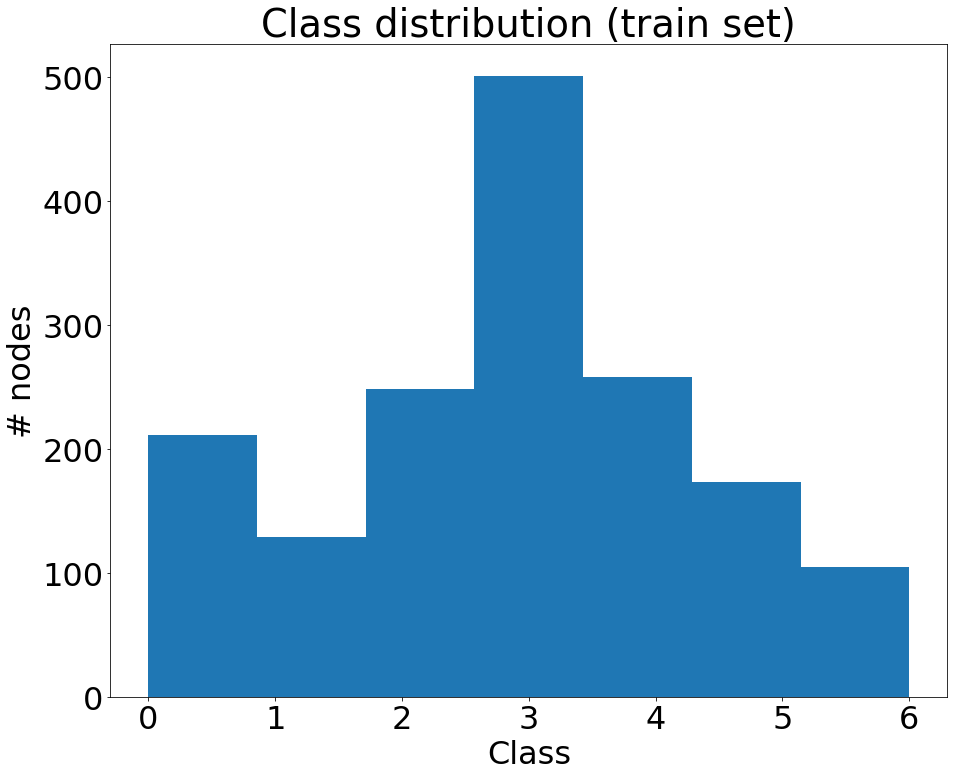

In [36]:
plt.title("Class distribution (train set)")
plt.hist(train_data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 325
graph has # isolated nodes: 205


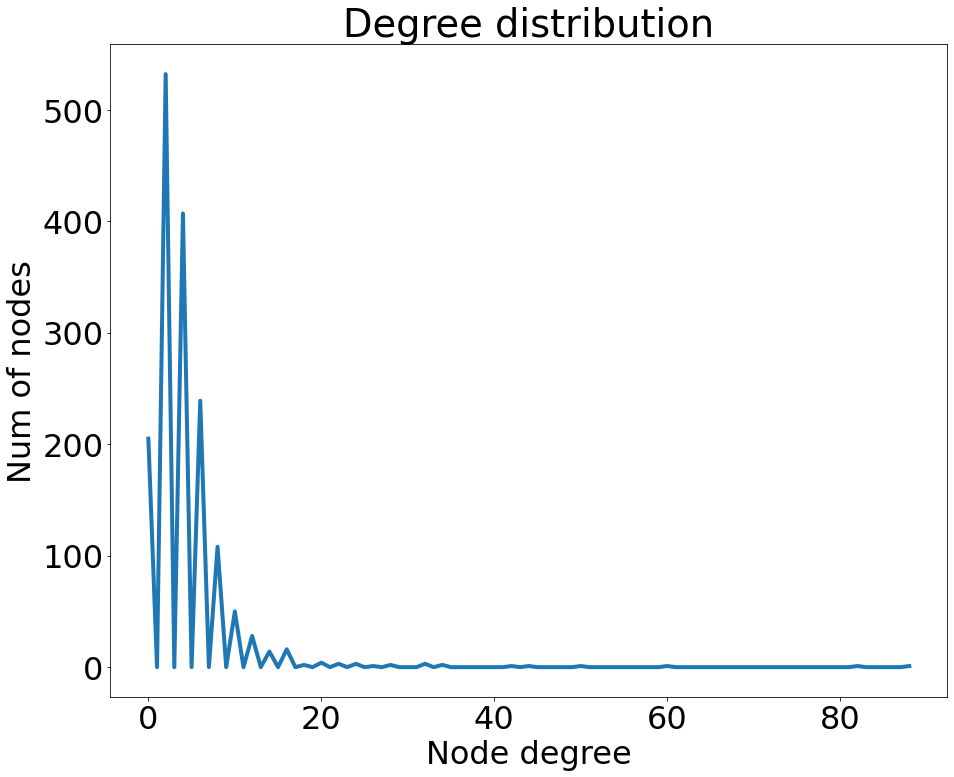

In [37]:
util.describe_graph(train_data)

## Inspect calibration data

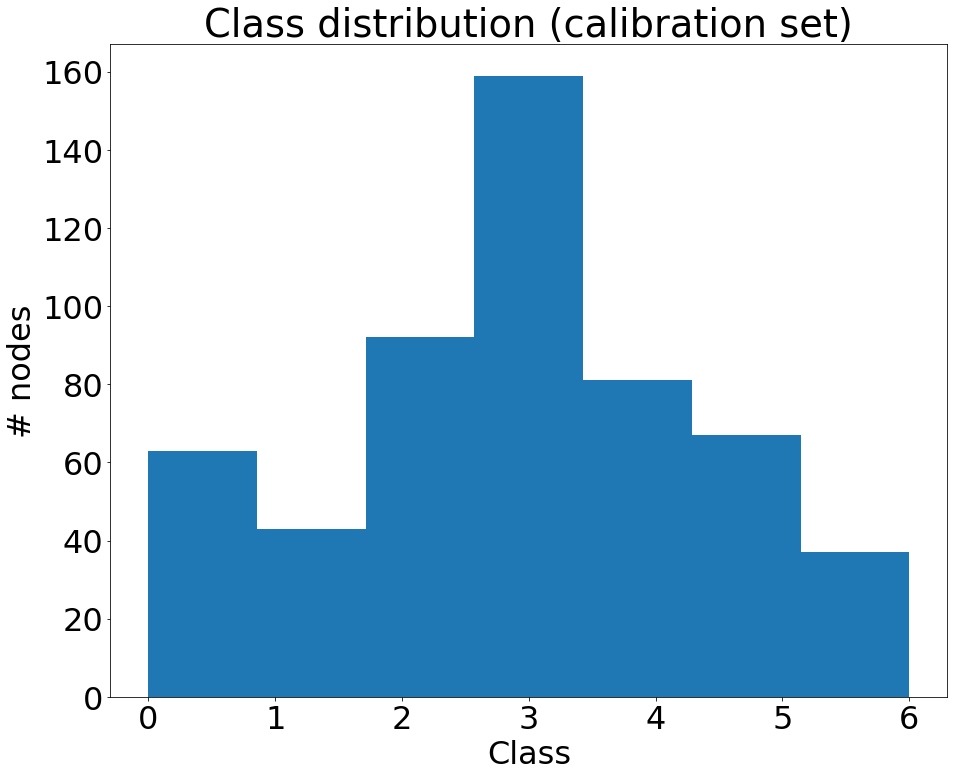

In [38]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[calibration_indices].reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

## Inspect test data

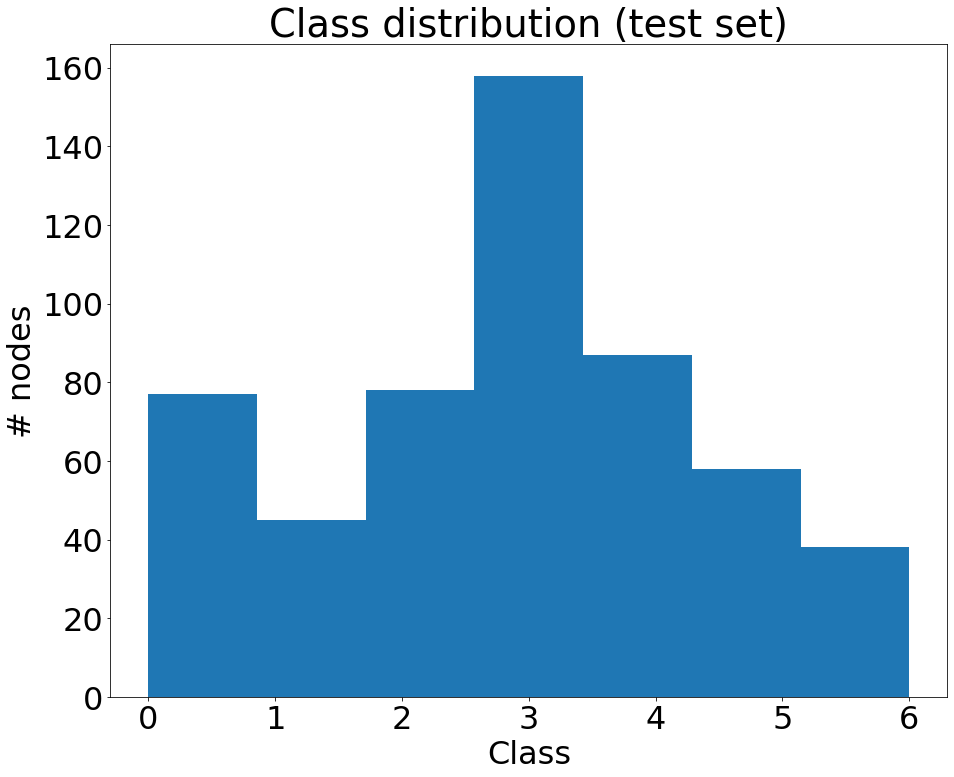

In [39]:
plt.title("Class distribution (test set)")
plt.hist(data.y[test_indices].reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

# GraphSAGE model

In [40]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    """
      sampling_size: number of neighbors to sample at each layer (list[int]).
    """
    super(GraphSAGE, self).__init__()

    self.num_layers = num_layers

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    # input layer
    self.convs.append(SAGEConv(in_channels=input_dim, out_channels=hidden_dim, aggr="mean"))
    self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # hidden layers
    for _ in range(0, num_layers-1):
      self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim, aggr="mean"))
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # output layer
    self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=output_dim, aggr="mean"))

    self.softmax = torch.nn.LogSoftmax(dim=1)

    self.dropout = 0.1

    self.return_embeds = False

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()

  def forward(self, x, adj_t):
    embedding = x
    for i, conv in enumerate(self.convs[:-1]):
      embedding = conv(x=embedding, edge_index=adj_t)
      embedding = self.bns[i](embedding)
      embedding = torch.nn.functional.relu(embedding)
      embedding = torch.nn.functional.dropout(embedding, p=self.dropout, training=self.training)
    
    # output layer
    embedding = self.convs[-1](x=embedding, edge_index=adj_t)

    node_class = self.softmax(embedding)

    if self.return_embeds:
      return node_class, embedding

    return node_class

  def train_model(self, data, optimizer, loss_fn):
    self.train()

    optimizer.zero_grad()
    
    out = self(data.x, data.edge_index)

    y_true = data.y.reshape(-1).detach()

    loss = loss_fn(out, y_true)

    loss.backward()
    optimizer.step()
  
  def predict(self, data):
    self.eval()
    
    if self.return_embeds:
        y_hat, embeddings = self(data.x, data.edge_index)
        return y_hat.clone().detach(), embeddings
        
    y_hat = self(data.x, data.edge_index)
    
    return y_hat.clone().detach()

  def set_return_embeds(self, return_embeds: bool):
    self.return_embeds = return_embeds


In [41]:
from lib.evaluation import get_multiclass_classification_performance

args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 50,
    "batch_size": 1734,
    "num_neighbors": [10],
}

model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

loss_fn = torch.nn.NLLLoss()

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

acc, balanced_acc = get_multiclass_classification_performance(y_hat, y_true)

print(f"Model found \n"
        f"Test acc: {100 * acc:.2f}%, "
        f"Test balanced acc: {100 * balanced_acc:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Model found 
Test acc: 86.88%, Test balanced acc: 86.43%


# K-means

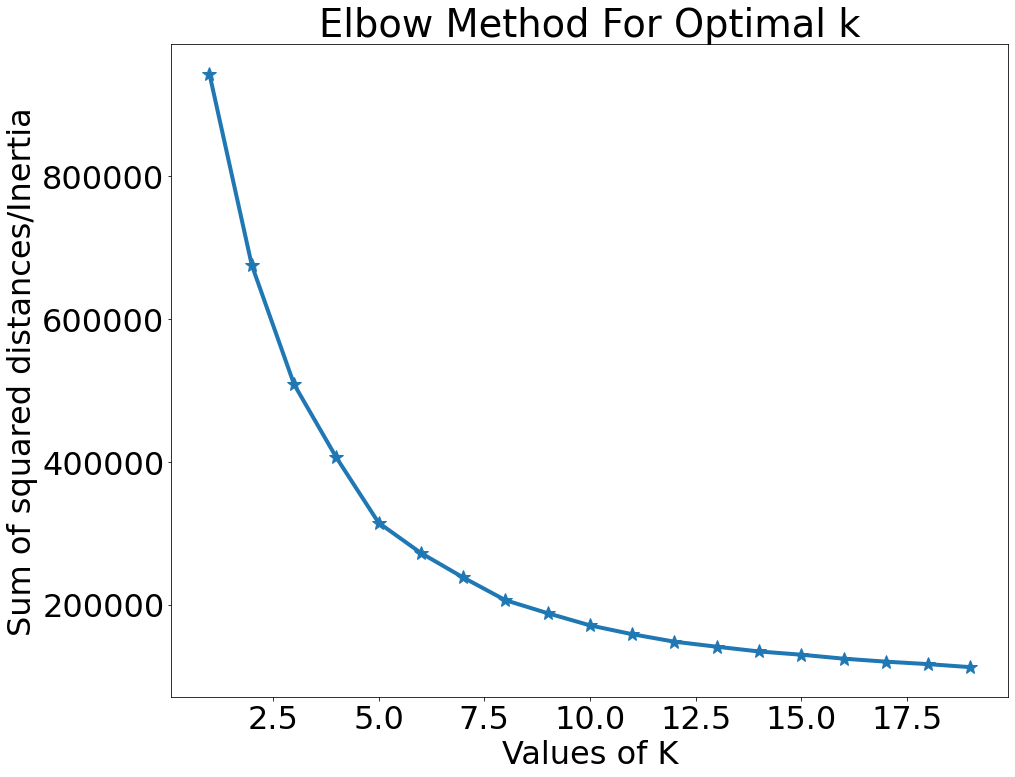

In [42]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

model.set_return_embeds(True)
_, embeds = model.predict(data)

Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(embeds.detach().numpy())
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"*-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [43]:
for e in embeds.detach():
    embedding_distance = torch.sum((embeds-e)**2, dim=1)
    print(torch.max(embedding_distance).detach().cpu().numpy(),torch.min(embedding_distance).detach().cpu().numpy(),torch.median(embedding_distance).detach().cpu().numpy())

2023.483 0.0 323.79974
2442.8608 0.0 478.62552
2296.088 0.0 445.11273
3558.7246 0.0 379.9969
2347.6675 0.0 294.03793
2997.8115 0.0 476.3278
2633.7856 0.0 547.656
2549.4653 0.0 320.21652
2331.2395 0.0 569.98645
3180.0479 0.0 493.82797
3098.642 0.0 560.19556
3258.3777 0.0 351.5938
2933.0056 0.0 505.29813
3343.51 0.0 1019.45544
2095.7568 0.0 465.2529
2539.5317 0.0 694.4348
3409.0168 0.0 939.31836
4268.45 0.0 1512.9751
3230.1572 0.0 460.10342
2245.4602 0.0 507.8848
4235.3125 0.0 742.9215
3389.1387 0.0 464.07416
2916.3735 0.0 1025.0687
4444.2363 0.0 854.68884
5038.208 0.0 2164.9153
2461.3408 0.0 287.60214
4757.766 0.0 1199.8588
2295.294 0.0 300.80646
3260.495 0.0 461.04175
2987.1655 0.0 480.4169
2187.7249 0.0 576.9262
4327.0435 0.0 601.4207
3585.2407 0.0 465.66797
2343.8354 0.0 527.8916
2953.5334 0.0 762.9594
3572.766 0.0 395.47095
3401.8472 0.0 544.6538
4233.0728 0.0 597.1427
2579.2405 0.0 521.81116
3021.003 0.0 1172.7542
2299.2556 0.0 492.0955
4861.04 0.0 815.6988
4769.164 0.0 975.74347
2